In [1]:
%matplotlib inline
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
# Load training data
nrows_train = 49
nrows_test = 51
X = np.loadtxt('xtrain_challenge.csv', delimiter=',', skiprows = 1)
Y = np.loadtxt('ytrain_challenge.csv', delimiter=',', skiprows = 1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_=scaler.transform(X)

The first step of our work was to try to understand the dataset we had to work on.
We had a total of 1,068,504 training observations from which we had to train a model to predict 3,318,296 test observations.
Each of the training observations, corresponding to two images, has 37 features and one label: 0 or 1. The label is 1 if the two images correspond to the same person, 0 otherwise. We are thus in the case of supervised learning and more precisely of binary classification.  


In [3]:
N=X.shape[0]
ordre=np.arange(0,N)
np.random.shuffle(ordre)

# Use as new variables
X=X[ordre[:]]
Y=Y[ordre[:]]
X_=X_[ordre[:]]

In [4]:
x_train=X[0:100000]
y_train=Y[0:100000]
x_train_scale=X_[0:100000]

x_test=X[100000:200000]
y_test=Y[100000:200000]
x_test_scale=X_[100000:200000]

x_train.shape

(100000, 37)

To get the best accuracy for our predictions, we have to work with good data.
Our first reflex was to use a linear transformation to standardize our data (mean=0 and std=1). We applied this to the training and the test set. This avoids that some features are more important than others for no reason.

Once we had our standardized data, the big question was: how are we going to divide our data?
Because we have over 1 million observations we knew that if we worked with all of them, the model training would be very long.
So we made the choice to shuffle our data and to work with 1/8 of the data at the beginning, at the risk of losing a little bit of accuracy. Once the model has been chosen, we will work with all the data.

We then divided our data into two sets, the training set, and the test set which will allow us to test our models, and above all to check that we haven't overfitted them. The latter is made up of 33% of the data retained.


In [5]:
count=0
for i in range(len(Y)):
    if Y[i]==1:
        count+=1
print("Nombre de données égales à 1 : "+str(count))
print("Nombre de données égales à 0 : "+str(len(Y)-count))
print("Pourcentage des données égales à 0 : "+str((len(Y)-count)*100/len(Y))+"%")

Nombre de données égales à 1 : 39593
Nombre de données égales à 0 : 1028911
Pourcentage des données égales à 0 : 96.29453890673315%


We soon noticed that the classes were very unbalanced.
Indeed, among the training observations, more than 96% of the data had the label 0.
We thought that we would have to adapt our algorithms to this imbalance because, it could be that our classifier only learns the majority class, and returns the label 0 for each data.
First of all, we thought we would do data augmentation, i.e. create new training observations from our training observations with label 0.


In [8]:
# Oversample and plot imbalanced dataset with SMOTE

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

oversample1 = SMOTE(sampling_strategy=0.2)
x_smote, y_smote = oversample1.fit_resample(x_train_scale, y_train)

oversample2 = RandomOverSampler(sampling_strategy=0.2)
x_overs,y_overs=oversample2.fit_resample(x_train_scale, y_train)

under1 = RandomUnderSampler(sampling_strategy=0.5)
x_sample1,y_sample1=under1.fit_resample(x_smote,y_smote)

under2 = RandomUnderSampler(sampling_strategy=0.5)
x_sample2,y_sample2=under2.fit_resample(x_overs,y_overs)

To to resolve the imbalance problem we use the following algorithms:
- The SMOTE algorithm artificially generates instances of the minority class based on the closest neighbors. 
- UnderSampling removes some instances of the majority class. 
- OverSampling multiplies the instances of the minority class in order to have repetitions.

We test two different ways to increase the number of minority data. The first one is the combination of SMOTE, and UnderSampling. The second is the combination of OverSampling and UnderSampling.

In [9]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1,figsize=(20,15))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores, random_state", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

## Decision Tree Classifier

We start with a simple classifier. 

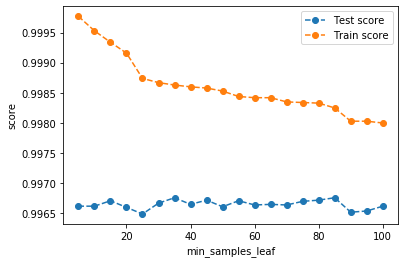

In [17]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
ab=np.linspace(1,10,10)
TTest=[]
TTrain=[]
for i in range(1,11):
  Tree = DecisionTreeClassifier(min_samples_split=i)
  Tree.fit(x_train_scale,y_train)
  TTrain.append(Tree.score(x_train_scale,y_train))
  TTest.append(Tree.score(x_test_scale,y_test))
    
plt.plot(ab,TTest,linestyle='--',marker='o',label='Test score')
plt.plot(ab,TTrain,linestyle='--',marker='o',label='Train score')
plt.xlabel("min_samples_leaf")
plt.ylabel("score")
plt.legend()

idx=TTest.index(min(TTest))
best_leaf=ab[idx]

You can see that taking a small min_number_leafs gives very different results on the test and train set. This is overfitting. 
Let's test with max_depth which allows to limit the depth of the tree. 

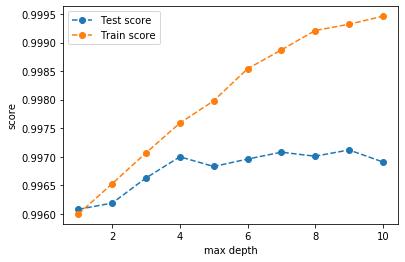

In [22]:
ab=np.linspace(1,10,10)
TTest=[]
TTrain=[]
for i in range(1,11):
  Tree = DecisionTreeClassifier(max_depth=i)
  Tree.fit(x_train_scale,y_train)
  TTrain.append(Tree.score(x_train_scale,y_train))
  TTest.append(Tree.score(x_test_scale,y_test))
    
plt.plot(ab,TTest,linestyle='--',marker='o',label='Test score')
plt.plot(ab,TTrain,linestyle='--',marker='o',label='Train score')
plt.xlabel("max depth")
plt.ylabel("score")
plt.legend()

idx=TTest.index(max(TTest))
best_depth=ab[idx]

The best result seems to be obtained for depth_max= 4. Indeed, beyond that the test score does not increase any more while the train score continues to increase. This means that beyond max_depth =4 we are overfitting. 

In [23]:
Tree1 = DecisionTreeClassifier(max_depth=best_depth)
Tree1.fit(x_train,y_train)
print("Imbalanced Dataset Not scaled")
print('Score in the training set is {0}'.format(Tree1.score(x_train,y_train)) )
print('Score in the test set is {0}'.format(Tree1.score(x_test,y_test)) )

Imbalanced Dataset Not scaled
Score in the training set is 0.99932
Score in the test set is 0.99715


In [24]:
Tree2 = DecisionTreeClassifier(max_depth=best_depth)
Tree2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",Tree2.score(x_train_scale,y_train))
print("Test score :",Tree2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99932
Test score : 0.9971


In [25]:
Tree3 = DecisionTreeClassifier(max_depth=best_depth)
Tree3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with Smote&UnderSample")
print("Training score :",Tree3.score(x_sample1,y_sample1))
print("Test score :",Tree3.score(x_test_scale,y_test))

Scaled data, balanced with Smote&UnderSample
Training score : 0.9978861281491492
Test score : 0.99443


In [26]:
Tree4 = DecisionTreeClassifier(max_depth=best_depth)   
Tree4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",Tree4.score(x_sample2,y_sample2))
print("Test score :",Tree4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 0.998925737256125
Test score : 0.99517


For the Simple Classify algorithm we notice that it is not useful to normalize the data. Increasing seems also useless, the results are less good when we use a driven shaft on the balanced data. Indeed SMOTE generates noise, while OverSampling encouraged overfitting. 

We therefore decide to test our data on unbalanced and non-scaled data. 

##### Submit result

In [32]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier(max_depth=best_depth)
clf.fit(X,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_tree_class.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.964844004272

The score is very low, indeed 96% of the data are labeled 0, so an algorithm returning only 0's will have a score close to 0.96 if the test set has the same distribution as the train set.

## Bagging

Let's use bagging to improve our weak learner's performance. Bagging consist of training many weak learners on differents data, chosen randomly. Weak learners achieve an accuracy that is just above random chance.  DecisionTreeClassifier is a weak learner. Bagging generates many Decision Tree, but each tree is created using only a part of the data, different at each time. 

n_estimators is the number of weak learner generated.

First we try with the best_tree we found at the last step (max_depth = 4).

In [36]:
from sklearn.ensemble import BaggingClassifier
Tree = DecisionTreeClassifier(max_depth=4)
p_grid_bagging = {'n_estimators': [50,75,100,150]}
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging_ = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
grid_bagging_.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                               class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=4,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                            

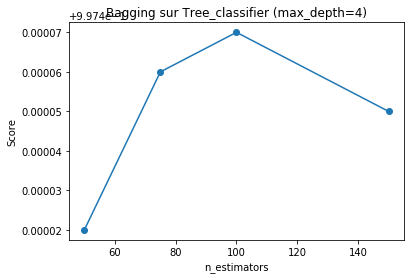

In [51]:
estimators=p_grid_bagging['n_estimators']
scores_mean = [grid_bagging_.cv_results_['mean_test_score'][i] for i in range(len(estimators))]
idx=scores_mean.index(max(scores_mean))
best_estimator_bag=p_grid_bagging['n_estimators'][idx]
plt.plot(estimators,scores_mean,marker='o')
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title('Bagging sur Tree_classifier (max_depth=4)')
plt.show()

Let's test this model on different types of data (scaled or not, balanced or not...)

In [52]:
Tree = DecisionTreeClassifier(max_depth=4)   
bag1=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag1.fit(x_train, y_train)
print("Imbalanced Dataset Not scaled")
print("Training score :",bag1.score(x_train,y_train))
print("Test score:",bag1.score(x_test,y_test))

Imbalanced Dataset Not scaled
Training score : 0.99806
Test score: 0.99737


In [53]:
bag2=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",bag2.score(x_train_scale,y_train))
print("Test score :",bag2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99806
Test score : 0.99737


In [54]:
bag3=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with Smote&UnderSample")
print("Training score :",bag3.score(x_sample1,y_sample1))
print("Test score :",bag3.score(x_test_scale,y_test))

Scaled data, balanced with Smote&UnderSample
Training score : 0.9946979935544236
Test score : 0.9953


In [55]:
Tree = DecisionTreeClassifier(max_depth=best_depth)   
bag4=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",bag4.score(x_sample2,y_sample2))
print("Test score :",bag4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 0.9986831617978307
Test score : 0.99628


#### Submit a result 

In [100]:
Tree = DecisionTreeClassifier(max_depth=4)   
clf_bag=BaggingClassifier(base_estimator=Tree,n_estimators=100, random_state=0)
clf_bag.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf_bag.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_bag.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.996794740433

We notice that for the first time, the SMOTE algorithm gets good results and does not create over-fitting. 
Indeed, the test score is higher than the training score ! Nonetheless the test score is higher on scaled and unbalanced data. 

Let's try testing other tree depths to see if we get better results.

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

depth=[2,4,6,8,10,12,14,16,18,20]
p_grid_bagging = {'n_estimators': [50,75,100,125,150,175,200]} 
score_bag=[]
parameters_bag=[]
best_score=0
save_grid_bag=[]
for i in depth:
    Tree = DecisionTreeClassifier(max_depth=i)   
    bag=BaggingClassifier(base_estimator=Tree, random_state=0)
    grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
    grid_bagging.fit(x_train, y_train)
    score_bag.append(grid_bagging.best_score_)
    parameters_bag.append(grid_bagging.best_params_)
    if grid_bagging.best_score_>best_score:
        save_grid_bag=[grid_bagging]
        best_score=grid_bagging.best_score_

Text(0.5, 1.0, 'Best GridSearch Score according to max_depth')

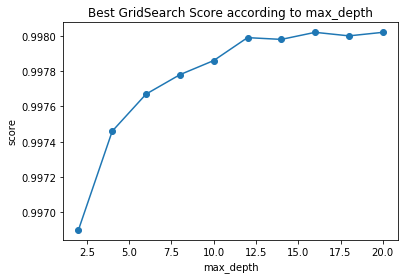

In [41]:
depth=[2,4,6,8,10,12,14,16,18,20]

idx=score_bag.index(max(score_bag))
best_depth_bag=depth[idx]
estimators_=[dic['n_estimators'] for dic in parameters_bag]
best_estimator_bag=estimators_[idx]

plt.figure()
plt.plot(depth,score_bag,marker='o')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('Best GridSearch Score according to max_depth')

Text(0.5, 1.0, 'Best GridSearch nb_estimator according to max_depth')

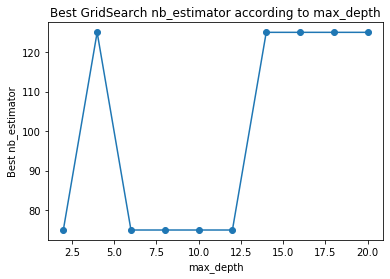

In [47]:
plt.figure()
plt.plot(depth,estimators_,marker='o')
plt.xlabel('max_depth')
plt.ylabel('Best nb_estimator')
plt.title('Best GridSearch nb_estimator according to max_depth')

However it seems that the deeper the tree is, the more instances of the weak learner we need. Multiplying the instances of the weak learner increases the computing time considerably. So we have to make a compromise between precision and computation time.


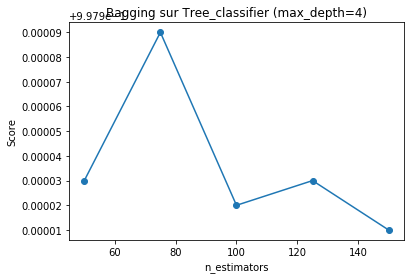

In [16]:
grid=save_grid_bag[0]
estimators=p_grid_bagging['n_estimators']
scores_mean = [grid.cv_results_['mean_test_score'][i] for i in range(len(estimators))]
idx=scores_mean.index(max(scores_mean))
best_estimator_bag=p_grid_bagging['n_estimators'][idx]
plt.plot(estimators,scores_mean,marker='o')
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title('Bagging sur Tree_classifier (max_depth=4)')
plt.show()

Let's test our best model on different types of data (scaled or not, balanced or not...)

In [17]:
Tree = DecisionTreeClassifier(max_depth=best_depth_bag)   
bag1=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag1.fit(x_train, y_train)
print("Imbalanced Dataset Not scaled")
print("Training score :",bag1.score(x_train,y_train))
print("Test score:",bag1.score(x_test,y_test))

Imbalanced Dataset Not scaled
Training score : 0.99956
Test score: 0.99784


In [18]:
Tree = DecisionTreeClassifier(max_depth=best_depth_bag)   
bag2=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",bag2.score(x_train_scale,y_train))
print("Test score :",bag2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 0.99956
Test score : 0.99784


In [19]:
Tree = DecisionTreeClassifier(max_depth=best_depth_bag)   
bag3=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with Smote&UnderSample")
print("Training score :",bag3.score(x_sample1,y_sample1))
print("Test score :",bag3.score(x_test_scale,y_test))

Scaled data, balanced with Smote&UnderSample
Training score : 0.9992052797069901
Test score : 0.99601


In [20]:
Tree = DecisionTreeClassifier(max_depth=best_depth_bag)   
bag4=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
bag4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",bag4.score(x_sample2,y_sample2))
print("Test score :",bag4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 0.9993262154037524
Test score : 0.99609


If the trees are too deep it creates some over-fitting. Indeed, the score difference between the training scores and validation score is wider. The Training sore increases a lot when we choose deeper trees, but not the validation score. 

#### Submit a Result

In [21]:

Tree = DecisionTreeClassifier(max_depth=best_depth_bag)   
clf_bag=BaggingClassifier(base_estimator=Tree,n_estimators=best_estimator_bag, random_state=0)
clf_bag.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf_bag.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_bag.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.99788445636

## AdaBoost et DecisionTreeClassifier

Adaboost generates a user-specified set of learners (otherwise it will randomly generate a set of weak learners).
AdaBoost is very efficient on weak learner. 

AdaBoost will learn the weights of how to add these weak learners to be a strong learner. The weight of each learner is learned based on whether he predicts a sample correctly or not. The weight of a learner which predicts a sample badly is reduced. This process is repeated until the algorithme converges.

Adaboost generates nb_estimators weak learners. For each weak learner created, the misclassification rate is calculated. The weight for the m-th classifier is $\theta_m = ln(\frac{1-error}{error})$. The weight is updated for each data point : $W_{m+1}(x_i,y_i) = \frac{W_m (x_i,y_i) \exp^{-\theta_m y_i f_m(xi)}}{Z} $ where Z is a normalization factor and $f_m( )$ is the m-th classifier.

The learning rate represents the contribution of each model to the weights. Reducing the learning rate forces the model to train slowly. It may help to prevent overfitting.

At first glance, it seems that using a large number of estimators and a learning rate close to 1 should give better results. So I made a first test.

In [32]:
from sklearn.ensemble import AdaBoostClassifier

depth=[1,5,10,15,20,25]
p_grid_Ada_Tree = {'n_estimators': [100,150,200],'learning_rate':[0.9,0.95,0.98],}
score_ada=[]
parameters_ada=[]
for i in depth:
    model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                               algorithm="SAMME")
    grid_ada_tree = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree, scoring="accuracy", cv=5)
    grid_ada_tree.fit(x_train_scale, y_train)
    score_ada.append(grid_ada_tree.best_score_)
    parameters_ada.append(grid_ada_tree.best_params_)

Text(0.5, 1.0, 'Best GridSearch Score according to max_depth')

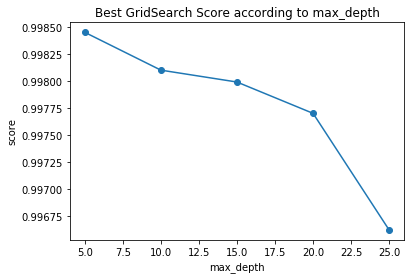

In [33]:
idx=score_ada.index(max(score_ada))
best_depth=depth[idx]
estimators_=parameters_ada['n_estimators']
lr_=parameters_ada['learning_rate']
best_estimator_=estimators_[idx]
best_lr_adaTree=lr_[idx]

plt.figure()
plt.plot(depth,score_ada,marker='o')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('Best GridSearch Score according to max_depth')

We can see that using a tree that is too deep immediately leads to poorer results. The simpler the weak-learner is, the more efficient AdaBoost is. Indeed, if the tree is to deep, it creates overfitting. 

Most of the time AdaBoost is tested with Decision Stump, which are trees whith one node and two leafs. 


To avoid overfitting, we can also reduce the learning rate. 
__Let's try a wider range of learning_rate.__

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

depth=[2,3,4,5,6,7]
p_grid_Ada_Tree2 = {'n_estimators': [100,150,200,250],'learning_rate':[0.1,0.3,0.5,0.7,0.9]}
score_ada2=[]
parameters_ada2=[]
best_score=0
save_grid=[]
for i in depth:
    model = AdaBoostClassifier(DecisionTreeClassifier(criterion="gini",max_depth=i, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
    grid_ada_Tree2 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree2, scoring="accuracy", cv=5)
    grid_ada_Tree2.fit(x_train_scale, y_train)
    score_ada2.append(grid_ada_Tree2.best_score_)
    parameters_ada2.append(grid_ada_Tree2.best_params_)
    if grid_ada_Tree2.best_score_>best_score:
        save_grid=[grid_ada_tree]
        best_score=grid_ada_tree.best_score_

Text(0.5, 1.0, 'Best GridSearch Score according to max_depth')

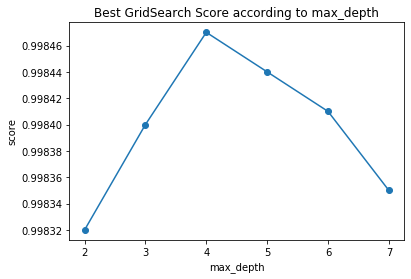

In [24]:
depth=[2,3,4,5,6,7]
idx=score_ada2.index(max(score_ada2))
best_depth=depth[idx]
estimators_=[dic['n_estimators'] for dic in parameters_ada2]
lr_=[dic['learning_rate'] for dic in parameters_ada2]
best_estimator_=estimators_[idx]
best_lr_adaTree=lr_[idx]

plt.figure()
plt.plot(depth,score_ada2,marker='o')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('Best GridSearch Score according to max_depth')

Text(0.5, 1.0, 'Best GridSearch nb_estimator according to max_depth')

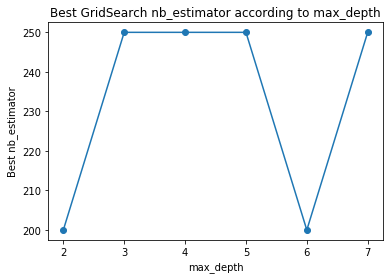

In [26]:
plt.figure()
plt.plot(depth,estimators_,marker='o')
plt.xlabel('max_depth')
plt.ylabel('Best nb_estimator')
plt.title('Best GridSearch nb_estimator according to max_depth')

Text(0.5, 1.0, 'Best GridSearch learning rate according to max_depth')

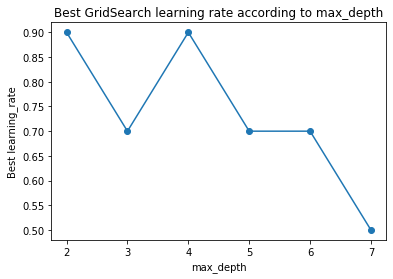

In [25]:
plt.figure()
plt.plot(depth,lr_,marker='o')
plt.xlabel('max_depth')
plt.ylabel('Best learning_rate')
plt.title('Best GridSearch learning rate according to max_depth')

It seems that the best learning rate decreases when the max_depth increases. If the max_depth is large, the odds of overfitting are high. Therefore, one should choose a small learning rate, to slow the learning down.

We have chosen the best tree depth 4, let's now study the impact of learning_rate and nb_estimators. 

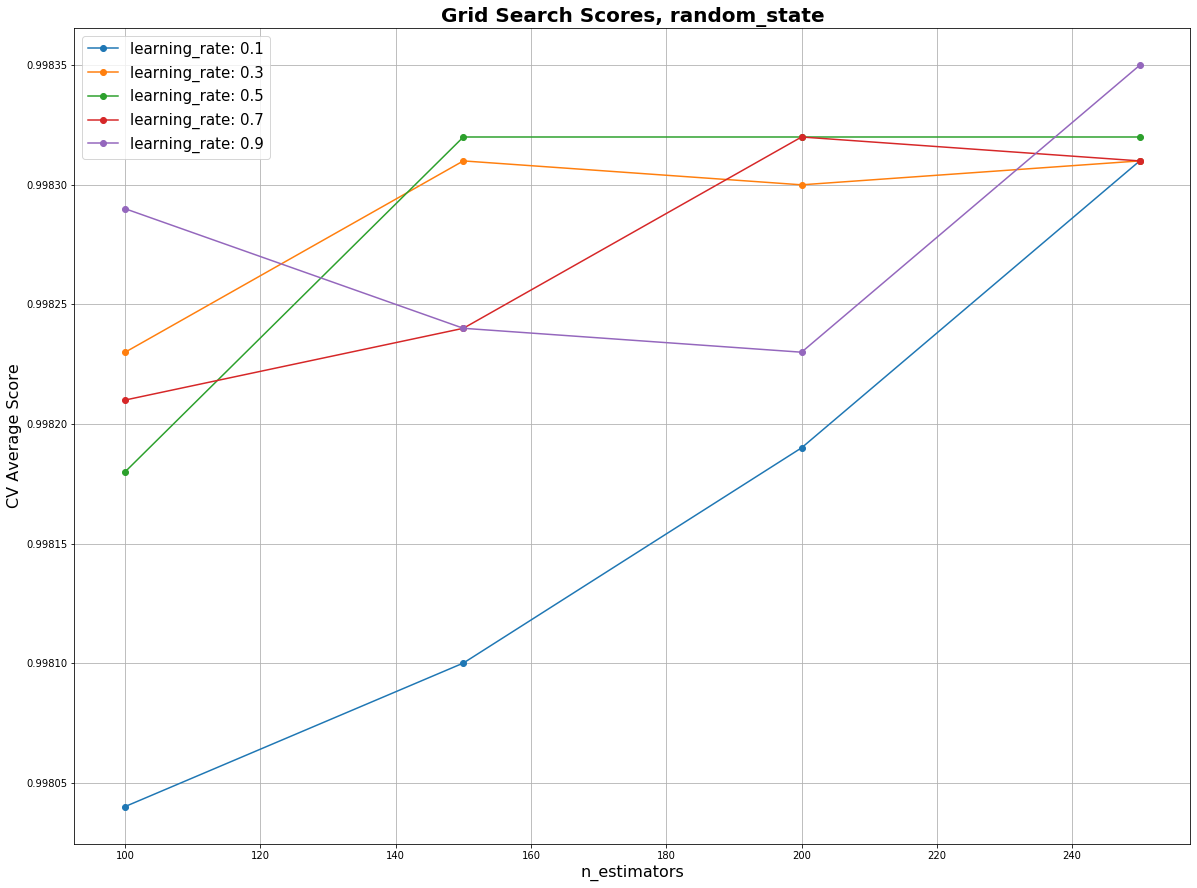

In [39]:
grid=save_grid[0]
plot_grid_search(grid.cv_results_,  p_grid_Ada_Tree2['n_estimators'],p_grid_Ada_Tree2['learning_rate'], 'n_estimators','learning_rate')

It seems that the score increases with n_estimators for most learning rates. 
If both the n_estimators and the learning rate are small, we obtain bad results. 
If the learning rate or the number of estimator is small, and the other is large, the results are not bad. 
But we get the best results chen the number of estimator and the number of 

Let's deepen our search for the best hyperparameters. We chose best_depth = 4.

Let's test the "gini" and "entropy" criterion of DecisionTreeClassifier.

### Gini Criterion

The Gini criterion measures how often a randomly chosen sample would be incorrectly classified. 

$$Gini=1-\sum_{j \in {0,1}} p_j^2$$
with $p_1$ and $p_0$ the probability to get a 1 or a 0 at each node.




In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

p_grid_Ada_Tree3 = {'n_estimators': [200,225,250],'learning_rate':[0.75,0.775,0.8,0.825,0.85,0.875,0.9,0.925,0.95,0.975,1]}

model = AdaBoostClassifier(DecisionTreeClassifier(criterion="gini",max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_Tree3 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree3, scoring="accuracy", cv=5)
grid_ada_Tree3.fit(x_train_scale, y_train)



GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
    

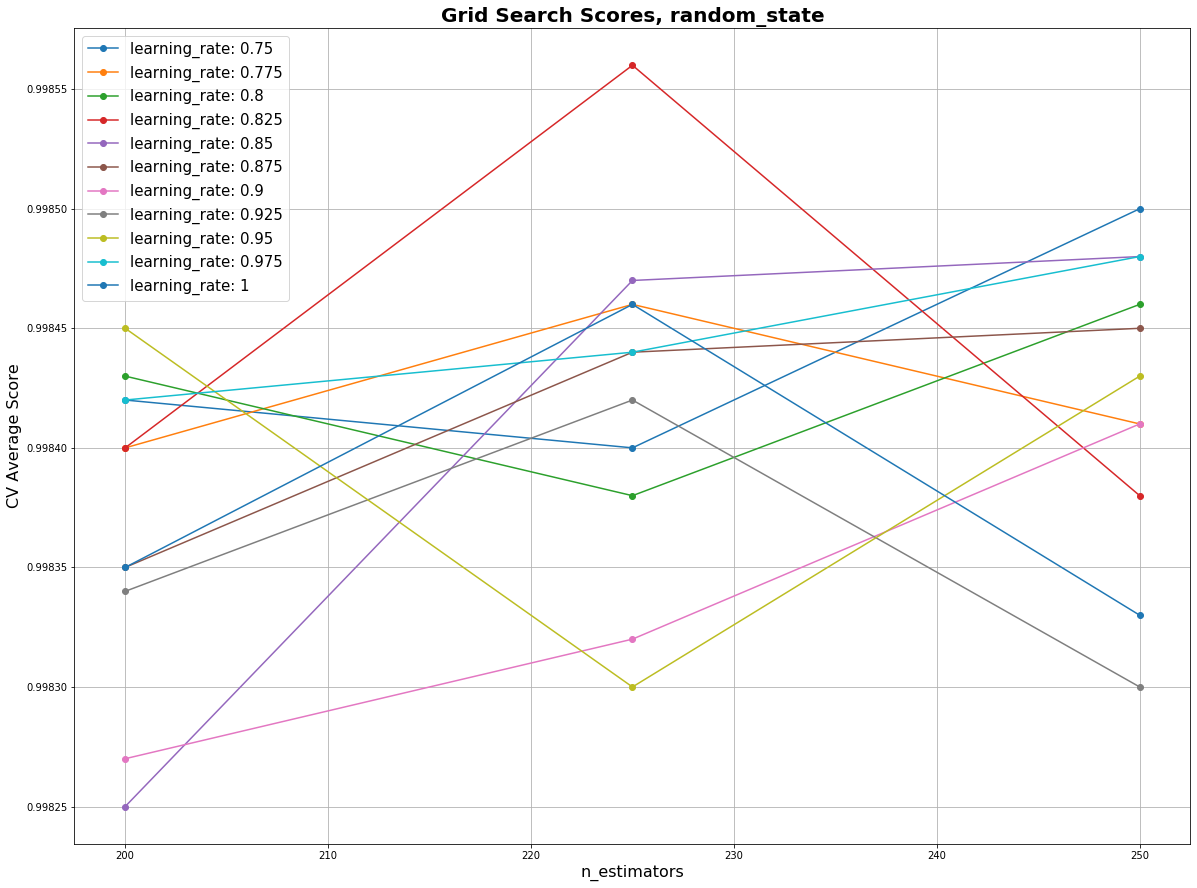

In [30]:
plot_grid_search(grid_ada_Tree3.cv_results_,  p_grid_Ada_Tree3['n_estimators'],p_grid_Ada_Tree3['learning_rate'], 'n_estimators','learning_rate')

Once again we observe that the score increase with the number of estimators for most learning_rates.

In [33]:
print("Best Score: {}".format(grid_ada_Tree3.best_score_))
print("Best params: {}".format(grid_ada_Tree3.best_params_))
best_estimator_=grid_ada_Tree3.best_params_['n_estimators']
best_lr_adaTree=grid_ada_Tree3.best_params_['learning_rate']
best_depth=4

Best Score: 0.99856
Best params: {'learning_rate': 0.825, 'n_estimators': 225}


Let's test our best model on different types of data (scaled or not, balanced or not...)

In [34]:
clf1= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf1.fit(x_train, y_train)
print("Imbalanced Dataset not scaled")
print("Training score :",clf1.score(x_train,y_train))
print("Test score :",clf1.score(x_test,y_test))

Imbalanced Dataset not scaled
Training score : 1.0
Test score : 0.99826


In [35]:
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",clf2.score(x_train_scale,y_train))
print("Test score :",clf2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 1.0
Test score : 0.99826


In [36]:
clf3= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",clf3.score(x_sample1,y_sample1))
print("Test score :",clf3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 1.0
Test score : 0.99771


In [37]:
clf4= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",clf4.score(x_sample2,y_sample2))
print("Test score :",clf4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.99798


##### Submit a result

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.998017657255

### Entropy Criterion 

The Entropy Criterion uses logarithm intead of simple probabilities. It measures the information gain at each node.

$$Entropy=- \sum_{j \in {0,1}} p_j log_2 (p_j)$$

with $p_1$ and $p_0$ the probability to get a 1 or a 0 at each node.


In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

p_grid_Ada_Tree4 = {'n_estimators': [200,225,250],'learning_rate':[0.75,0.775,0.8,0.825,0.85,0.875,0.9,0.925,0.95,0.975,1]}

model = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy",max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_Tree4 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree4, scoring="accuracy", cv=5)
grid_ada_Tree4.fit(x_train_scale, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='entropy',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

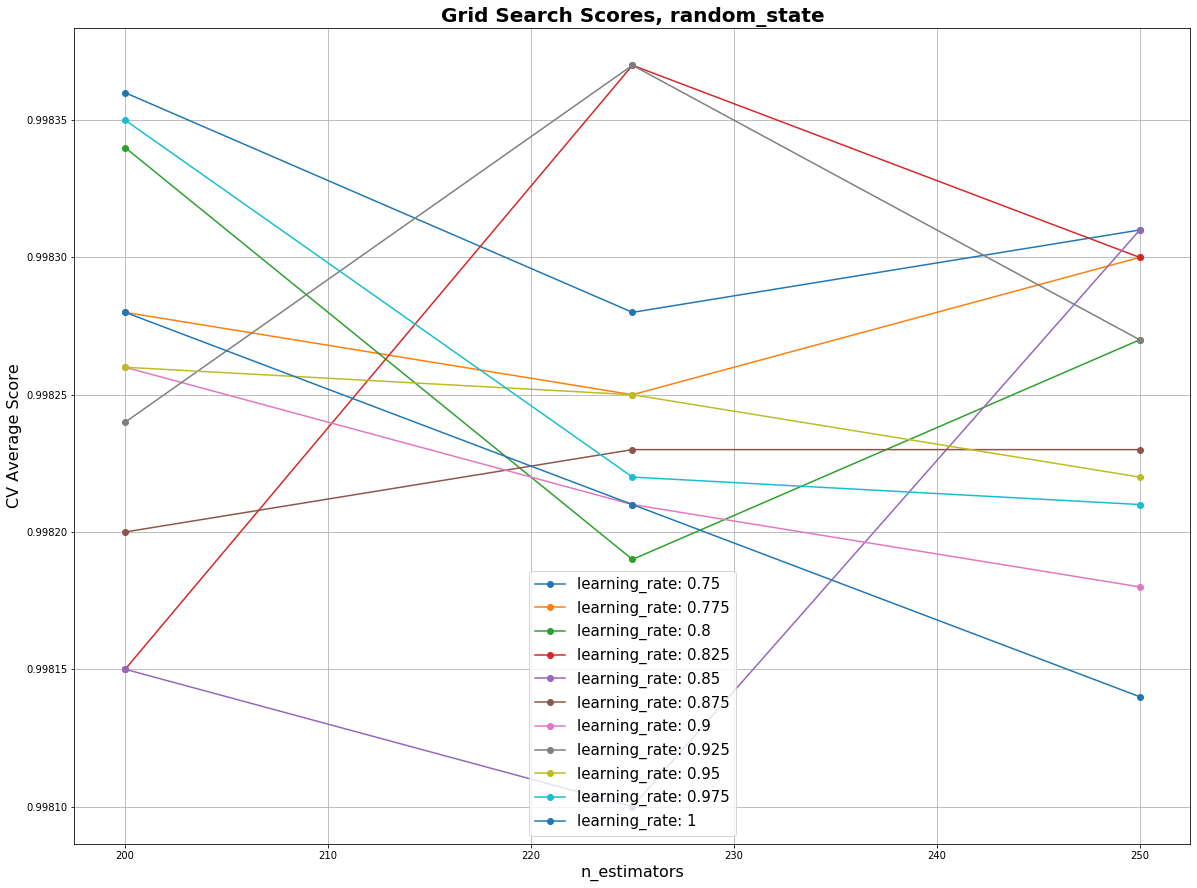

In [23]:
plot_grid_search(grid_ada_Tree4.cv_results_,  p_grid_Ada_Tree4['n_estimators'],p_grid_Ada_Tree4['learning_rate'], 'n_estimators','learning_rate')

It seems that for large learning rate, the score decreases chen the number of estimators increase. 

On the contrary, for the Gini criterion, we need more estimators to get better scores. 

If we need to use smaller number of estimators with the entropy criterion than with the gini criterion, using the entropy criterion may be useful in order to reduce computationnal time.

In [24]:
print("Best Score: {}".format(grid_ada_Tree4.best_score_))
print("Best params: {}".format(grid_ada_Tree4.best_params_))
best_estimator_=grid_ada_Tree4.best_params_['n_estimators']
best_lr_adaTree=grid_ada_Tree4.best_params_['learning_rate']
best_depth=4

Best Score: 0.9983700000000001
Best params: {'learning_rate': 0.925, 'n_estimators': 225}


In [83]:
best_estimator_=225
best_lr_adaTree=0.925

In fact there are two bests learning rates : 0.925 and 0.825, so we'll try both.

##### Learning rate = 0.925

In [84]:
clf1= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf1.fit(x_train, y_train)
print("Imbalanced Dataset not scaled")
print("Training score :",clf1.score(x_train,y_train))
print("Test score :",clf1.score(x_test,y_test))

Imbalanced Dataset not scaled
Training score : 1.0
Test score : 0.99833


In [85]:
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",clf2.score(x_train_scale,y_train))
print("Test score :",clf2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 1.0
Test score : 0.99833


In [86]:
clf3= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",clf3.score(x_sample1,y_sample1))
print("Test score :",clf3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 1.0
Test score : 0.99794


In [87]:
clf4= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",clf4.score(x_sample2,y_sample2))
print("Test score :",clf4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.99813


##### Submit a Result

In [88]:
#Learning rate 0.925
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=4,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.998062861179

##### Learning rate = 0.825



In [89]:
best_lr_adaTree=0.825

In [90]:
clf1= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf1.fit(x_train, y_train)
print("Imbalanced Dataset not scaled")
print("Training score :",clf1.score(x_train,y_train))
print("Test score :",clf1.score(x_test,y_test))

Imbalanced Dataset not scaled
Training score : 1.0
Test score : 0.99841


In [91]:
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",clf2.score(x_train_scale,y_train))
print("Test score :",clf2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 1.0
Test score : 0.99843


In [92]:
clf3= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",clf3.score(x_sample1,y_sample1))
print("Test score :",clf3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 1.0
Test score : 0.99785


In [93]:
clf4= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",clf4.score(x_sample2,y_sample2))
print("Test score :",clf4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.99805


#### Submit a result

In [94]:
#Learning rate 0.825
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=4,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree2.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.998045985048

The first learning rate gets better results

#### Entropy or Gini conclusion :



| criterion | Gini | Entropy (learning_rate =0.825) | Entropy (learning_rate =0.925) |
|---|---|---|---|
| Validation score | 0.99826 | 0.99841| 0.99833 |
| Testing score  |   0.998017657255|  0.998045985048| 0.998062861179|

We choose entropy as the new criterion. 

### Class Weights in DecisionTreeClassifier


Finally, my last attempt to try to improve this model was to test the weight of the classes. I tried different weights in DecisionTreeClassifier : weights1 = {0:1,1:10}, weights2 = {0:1,1:5}. 
With weights 1 we balance the dataset, but the risks of over-fitting are higher. 

###### weights = {0:1,1:5}

In [65]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

p_grid_Ada_Tree5 = {'n_estimators': [100,125,150,175,200,225,250],'learning_rate':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]}

model = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy",class_weight={0:1,1:5}, max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_Tree5 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree5, scoring="accuracy", cv=5)
grid_ada_Tree5.fit(x_train_scale, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight={0: 1,
                                                                                              1: 5},
                                                                                criterion='entropy',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,

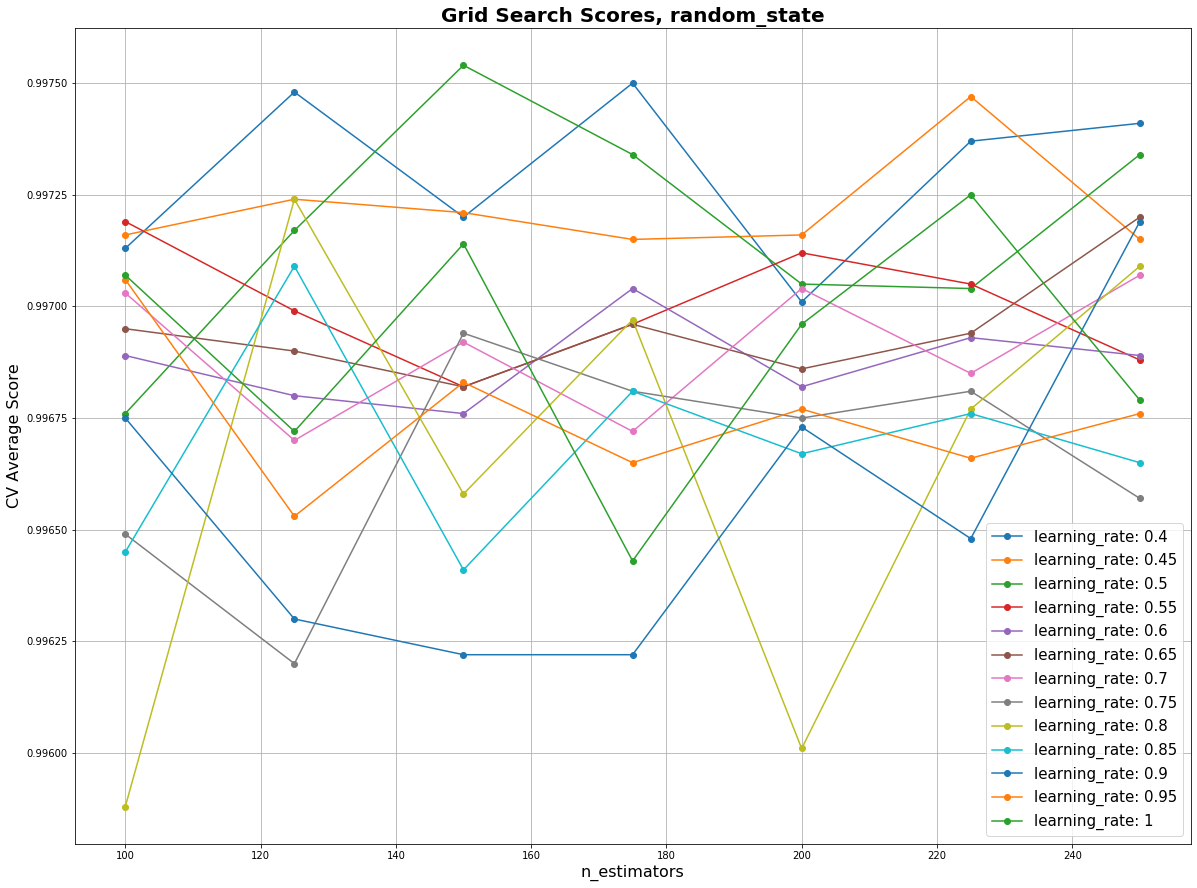

In [66]:
plot_grid_search(grid_ada_Tree5.cv_results_,  p_grid_Ada_Tree5['n_estimators'],p_grid_Ada_Tree5['learning_rate'], 'n_estimators','learning_rate')

In [67]:
print("Best Score: {}".format(grid_ada_Tree5.best_score_))
print("Best params: {}".format(grid_ada_Tree5.best_params_))
best_estimator_=grid_ada_Tree5.best_params_['n_estimators']
best_lr_adaTree=grid_ada_Tree5.best_params_['learning_rate']
best_depth=4

Best Score: 0.9975400000000001
Best params: {'learning_rate': 0.5, 'n_estimators': 150}


###### weights = {0:1,1:10}

In [68]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy",class_weight={0:1,1:10}, max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_Tree5 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree5, scoring="accuracy", cv=5)
grid_ada_Tree5.fit(x_train_scale, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight={0: 1,
                                                                                              1: 10},
                                                                                criterion='entropy',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None

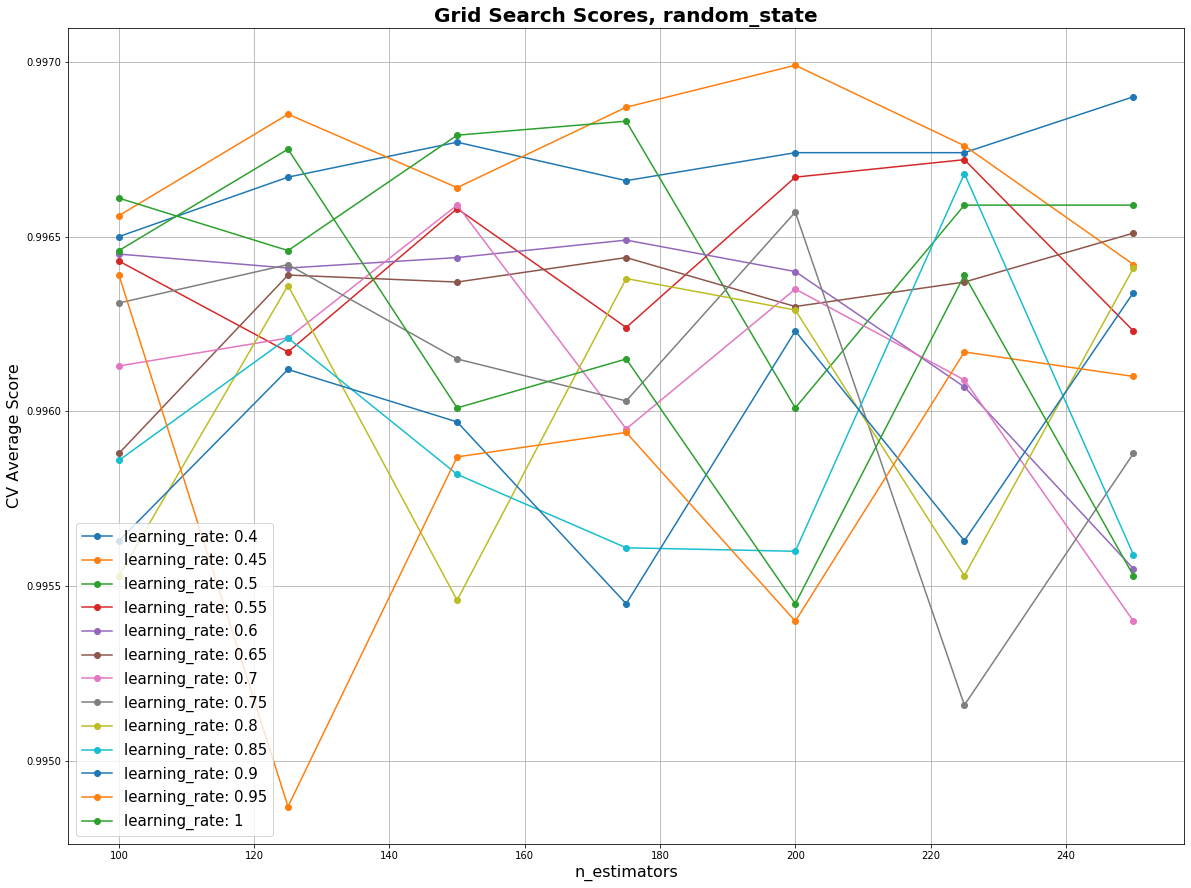

In [69]:
plot_grid_search(grid_ada_Tree5.cv_results_,  p_grid_Ada_Tree5['n_estimators'],p_grid_Ada_Tree5['learning_rate'], 'n_estimators','learning_rate')

In [70]:
print("Best Score: {}".format(grid_ada_Tree5.best_score_))
print("Best params: {}".format(grid_ada_Tree5.best_params_))
best_estimator_=grid_ada_Tree5.best_params_['n_estimators']
best_lr_adaTree=grid_ada_Tree5.best_params_['learning_rate']
best_depth=4

Best Score: 0.9969899999999999
Best params: {'learning_rate': 0.45, 'n_estimators': 200}


Comme nous nous y attendions, utiliser un poids trop grand pour la classe minoriaire ne permet pas d'obtenir de très bons résultats.

###### weights = {0:1,1:2}

In [71]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy",class_weight={0:1,1:2}, max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_Tree6 = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree5, scoring="accuracy", cv=5)
grid_ada_Tree6.fit(x_train_scale, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight={0: 1,
                                                                                              1: 2},
                                                                                criterion='entropy',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,

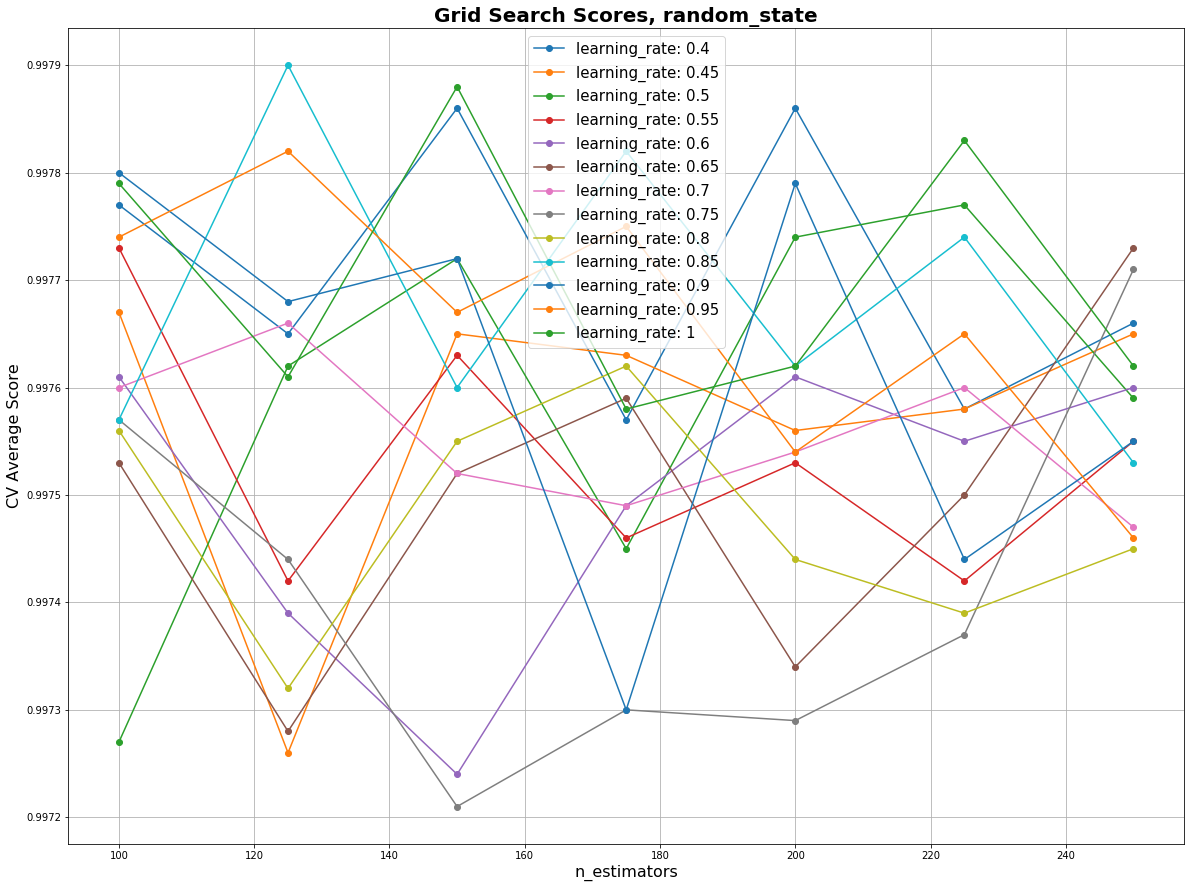

In [72]:
plot_grid_search(grid_ada_Tree6.cv_results_,  p_grid_Ada_Tree5['n_estimators'],p_grid_Ada_Tree5['learning_rate'], 'n_estimators','learning_rate')

In [73]:
print("Best Score: {}".format(grid_ada_Tree6.best_score_))
print("Best params: {}".format(grid_ada_Tree6.best_params_))
best_estimator_=grid_ada_Tree5.best_params_['n_estimators']
best_lr_adaTree=grid_ada_Tree5.best_params_['learning_rate']
best_depth=4

Best Score: 0.9978999999999999
Best params: {'learning_rate': 0.85, 'n_estimators': 125}


__None of the weights tested get better results than the {0:1, 1:1}.__
In moreover, it seems that the possible spaces of the hyper-parameters are much more complex when we use different weights. 

##### Submit a result ( weights {0:1,1:2} )

In [74]:
clf2=AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy",class_weight={0:1,1:2}, max_depth=4, random_state=26, max_features='sqrt'),
                               n_estimators=125,learning_rate=0.85,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_tree_weights.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.995669464086

## Last research of hyperparameters

In [75]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

p_grid_Ada_Tree = {'n_estimators': [125,150,175,200,225,250],'learning_rate':[0.9,0.925,0.95,0.975,1]}

model = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy",max_depth=4, random_state=26, max_features='sqrt'),
                               algorithm="SAMME")
grid_ada_Tree = GridSearchCV(estimator=model, param_grid=p_grid_Ada_Tree, scoring="accuracy", cv=5)
grid_ada_Tree.fit(x_train_scale, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='entropy',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

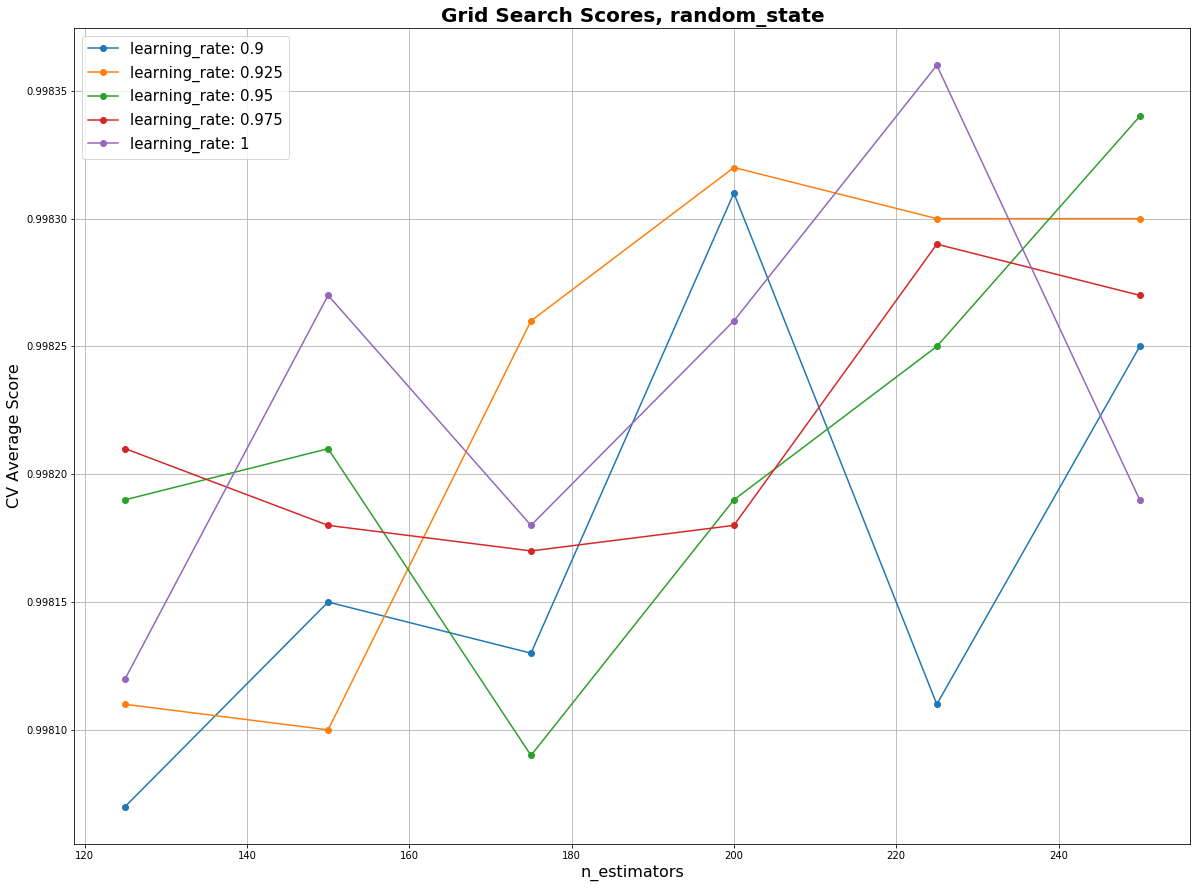

In [77]:
plot_grid_search(grid_ada_Tree.cv_results_,  p_grid_Ada_Tree['n_estimators'],p_grid_Ada_Tree['learning_rate'], 'n_estimators','learning_rate')

In [78]:
print("Best Score: {}".format(grid_ada_Tree.best_score_))
print("Best params: {}".format(grid_ada_Tree.best_params_))
best_estimator_=grid_ada_Tree.best_params_['n_estimators']
best_lr_adaTree=grid_ada_Tree.best_params_['learning_rate']
best_depth=4

Best Score: 0.9983599999999999
Best params: {'learning_rate': 1, 'n_estimators': 225}


In [102]:
clf1= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf1.fit(x_train, y_train)
print("Imbalanced Dataset not scaled")
print("Training score :",clf1.score(x_train,y_train))
print("Test score :",clf1.score(x_test,y_test))

Imbalanced Dataset not scaled
Training score : 1.0
Test score : 0.99834


In [103]:
clf2=AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf2.fit(x_train_scale, y_train)
print("Imbalanced Dataset scaled")
print("Training score :",clf2.score(x_train_scale,y_train))
print("Test score :",clf2.score(x_test_scale,y_test))

Imbalanced Dataset scaled
Training score : 1.0
Test score : 0.99833


In [104]:
clf3= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf3.fit(x_sample1, y_sample1)
print("Scaled data, balanced with SMOTE&UnderSample")
print("Training score :",clf3.score(x_sample1,y_sample1))
print("Test score :",clf3.score(x_test_scale,y_test))

Scaled data, balanced with SMOTE&UnderSample
Training score : 1.0
Test score : 0.99783


In [105]:
clf4= AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth,criterion="entropy"),
                        n_estimators=best_estimator_,learning_rate=best_lr_adaTree,algorithm="SAMME")
clf4.fit(x_sample2, y_sample2)
print("Scaled data, balanced with OverSample&UnderSample")
print("Training score :",clf4.score(x_sample2,y_sample2))
print("Test score :",clf4.score(x_test_scale,y_test))

Scaled data, balanced with OverSample&UnderSample
Training score : 1.0
Test score : 0.99806


#### Submit a result

In [98]:
clf2=AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=26, max_features='sqrt'),
                               n_estimators=225,learning_rate=1,algorithm="SAMME")
clf2.fit(X_,Y)
# Load test data
xtest = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)
# Classify the provided test data
ytest = clf2.predict(scaler.transform(xtest))
print(ytest.shape)
np.savetxt('ytest_adaB_final.csv', ytest, fmt = '%1.0d', delimiter=',')

(3318296,)


Score : 0.997909167838

Paradoxically, we were getting better results before refining our research. This can be explained by the fact that GridSearchCV uses cross validation, and therefore the results obtained depend on how the data are distributed in the cross validation sets. Also, the score on hidden test data is worse than before. 

We could do further research on the best hyper-parameters, but this requires a lot of computational time, and I prefer to test other models in the next Notebook.
